# Getting Started with TensorRT

TensorRT is an SDK for optimizing trained deep learning models to enable high-performance inference. TensorRT contains a deep learning inference __optimizer__ for trained deep learning models and an optimized __runtime__ for execution. After you have trained your deep learning model in a framework of your choice, TensorRT enables you to run it with higher throughput and lower latency. 

The TensorRT ecosystem breaks broadly down into two parts:
<br><br><br>
![TensorRT Landscape](./images/tensorrt_landscape.png)
<br><br><br>
Essentially,

1. The various paths users can follow to convert their models to optimized TensorRT engines
2. The various runtimes users can target with TensorRT when deploying their optimized TensorRT engines

If you have a model in Tensorflow or PyTorch and want to run inference as efficiently as possible - with low latency, high throughput, and less memory consumption - this guide will help you achieve just that!!
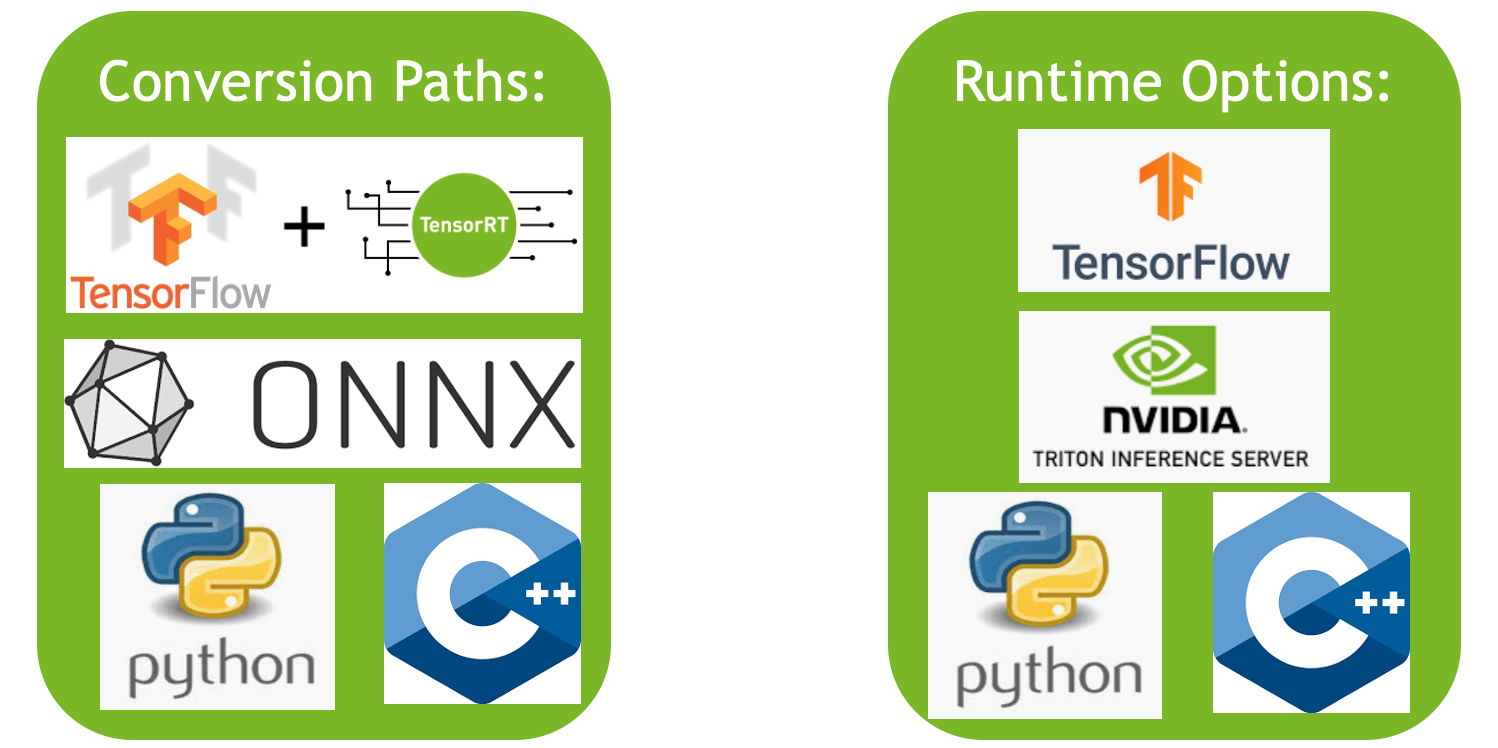

## How Do I Use TensorRT:

TensorRT is a large and flexible project. It can handle a variety of workflows, and which workflow is best for you will depend on your specific use-case and problem setting. Abstractly, the process for deploying a model from a deep learning framework to TensorRT looks like this:

![TensorRT Workflow](./images/tensorrt_workflow.png)

To help you get there, this guide will help you answer five key questions:

1. __What format should I save my model in?__
2. __What batch size(s) am I running inference at?__
3. __What precision am I running inference at?__
4. __What TensorRT path am I using to convert my model?__
5. __What runtime am I targeting?__

This guide will walk you broadly through all of these decision points while giving you an overview of your options at each step.

We could talk about these points in isolation, but they are best understood in the context of an actual end-to-end workflow. Let's get started on a simple one here, using a TensorRT API wrapper written for this guide. Once you understand the basic workflow, you can dive into the more in depth notebooks on the TF-TRT and ONNX converters!

## Simple TensorRT Demonstration through ONNX:

There are several ways of approaching TensorRT conversion and deployment. Here, we will take a pretrained ResNet50 model, convert it to an optimized TensorRT engine, and run it in the TensorRT runtime.

For this simple demonstration we will focus the ONNX path - one of the two main automatic approaches for TensorRT conversion. We will then run the model in the TensorRT Python API using a simplified wrapper written for this guide. Essentially, we will follow this path to convert and deploy our model:

![ONNX Conversion](./images/onnx_onnx.png)

We will follow the five questions above. For a more in depth discussion, the section following this demonstration will cover options available at these steps in more detail.

__IMPORTANT NOTE:__ Please __shutdown all other notebooks and Tensorflow/PyTorch processes__ before running these steps. TensorRT and Tensorflow/PyTorch can not be loaded into your Python processes at the same time.

#### 1. What format should I save my model in?

The two main automatic conversion paths for TensorRT require different model formats to successfully convert a model. TF-TRT uses Tensorflow SavedModels, and the ONNX path requires models be saved in ONNX. Here, we will use ONNX.

We are going to use ResNet50 - a basic backbone vision model that can be used for a variety of purposes. For the sake of demonstration, here we will perform classification using a __pretrained ResNet50 ONNX__ model included with the [ONNX model zoo](https://github.com/onnx/models).

We can download a pretrained ResNet50 from the ONNX model zoo and untar it by doing the following:

In [1]:
!wget https://s3.amazonaws.com/download.onnx/models/opset_8/resnet50.tar.gz -O resnet50.tar.gz
!tar xzf resnet50.tar.gz

--2021-01-30 00:56:52--  https://s3.amazonaws.com/download.onnx/models/opset_8/resnet50.tar.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.17.118
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.17.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 101706397 (97M) [binary/octet-stream]
Saving to: ‘resnet50.tar.gz’

resnet50.tar.gz     100%[===================>]  96.99M  17.3MB/s    in 17s     

2021-01-30 00:57:10 (5.55 MB/s) - ‘resnet50.tar.gz’ saved [101706397/101706397]



See how to export ONNX models that will work with this same trtexec command in the [Tensorflow through ONNX notebook](./3.%20Using%20Tensorflow%202%20through%20ONNX.ipynb), and in the [PyTorch through ONNX notebook](./4.%20Using%20PyTorch%20through%20ONNX.ipynb).

####  2. Which batch size(s) will I use?

Batch size can have a large effect on the optimizations TensorRT performs on our model. When using ONNX, we need to tell TensorRT what batch size to expect. Additionally, we need to tell TensorRT whether to expect a fixed batch size, or a range of batch sizes.

TensorRT is capable of handling the batch size dynamically if you don’t know until runtime what exact batch size you will need. That said, a fixed batch size allows TensorRT to make additional optimizations. For this example workflow, we use a fixed batch size of 32. 

We set the batch size when we save our model (see [the Tensorflow through ONNX notebook](./3.%20Using%20Tensorflow%202%20through%20ONNX.ipynb)), and we tell TensorRT to expect a fixed batch size by setting the _--explicitBatch_ flag in our __trtexec__ command when converting our model below.

In [2]:
import numpy as np

BATCH_SIZE=32

#### 3. What precision will I use?

Inference typically requires less numeric precision than training. With some care, lower precision can give you faster computation and lower memory consumption without sacrificing any meaningful accuracy. TensorRT supports TF32, FP32, FP16, and INT8 precisions.

FP32 is the default training precision of most frameworks, so we will start by using FP32 for inference here. Let's create a "dummy" batch to work with in order to test our model. TensorRT will use the precision of the input batch throughout the rest of the network by default.

In [3]:
PRECISION = np.float32

dummy_input_batch = np.zeros((BATCH_SIZE, 224, 224, 3), dtype=PRECISION)

#### 4. What TensorRT path am I using to convert my model?

The ONNX conversion path is one of the most universal and performant paths for automatic TensorRT conversion. It works for Tensorflow, PyTorch, and many other frameworks. There are several tools to help users convert models from ONNX to a TensorRT engine. 

One common approach is to use trtexec - a command line tool included with TensorRT that can, among other things, convert ONNX models to TensorRT engines and profile them.

In [4]:
!trtexec --onnx=resnet50/model.onnx --saveEngine=resnet_engine_intro.trt  --explicitBatch

&&&& RUNNING TensorRT.trtexec # trtexec --onnx=resnet50/model.onnx --saveEngine=resnet_engine_intro.trt --explicitBatch
[01/30/2021-00:57:12] [I] === Model Options ===
[01/30/2021-00:57:12] [I] Format: ONNX
[01/30/2021-00:57:12] [I] Model: resnet50/model.onnx
[01/30/2021-00:57:12] [I] Output:
[01/30/2021-00:57:12] [I] === Build Options ===
[01/30/2021-00:57:12] [I] Max batch: explicit
[01/30/2021-00:57:12] [I] Workspace: 16 MiB
[01/30/2021-00:57:12] [I] minTiming: 1
[01/30/2021-00:57:12] [I] avgTiming: 8
[01/30/2021-00:57:12] [I] Precision: FP32
[01/30/2021-00:57:12] [I] Calibration: 
[01/30/2021-00:57:12] [I] Refit: Disabled
[01/30/2021-00:57:12] [I] Safe mode: Disabled
[01/30/2021-00:57:12] [I] Save engine: resnet_engine_intro.trt
[01/30/2021-00:57:12] [I] Load engine: 
[01/30/2021-00:57:12] [I] Builder Cache: Enabled
[01/30/2021-00:57:12] [I] NVTX verbosity: 0
[01/30/2021-00:57:12] [I] Tactic sources: Using default tactic sources
[01/30/2021-00:57:12] [I] Input(s)s format: fp32:CHW


__Notes on the flags above:__
    
Tell trtexec where to find our ONNX model:

    --onnx=resnet50/model.onnx 

Tell trtexec where to save our optimized TensorRT engine:

    --saveEngine=resnet_engine_intro.trt

Tell trtexec to expect a fixed batch size when optimizing (the exact value of this batch size will be inferred from the ONNX file)

    --explicitBatch

####  5. What runtime will I use?

After we have our TensorRT engine created successfully, we need to decide how to run it with TensorRT.

There are two types of TensorRT runtimes: a standalone runtime which has C++ and Python bindings, and a native integration into TensorFlow. In this section, we will use a simplified wrapper (ONNXClassifierWrapper) which calls the standalone runtime. 

In [7]:
# If you get an error in this cell, restart your notebook (possibly your whole machine) and do not run anything that imports/uses Tensorflow/PyTorch

from onnx_helper import ONNXClassifierWrapper
trt_model = ONNXClassifierWrapper("resnet_engine_intro.trt", [BATCH_SIZE, 1000], target_dtype = PRECISION)

__Note__: If this conversion fails, please restart your Jupyter notebook kernel (in menu bar Kernel->Restart Kernel) and run steps 3 to 5 again. If you get an error like 'TypeError: pybind11::init(): factory function returned nullptr' there is likely some dangling process on the GPU - restart your machine and try again.

We will feed our batch of randomized dummy data into our ONNXClassifierWrapper to run inference on that batch:

In [8]:
# Warm up:
trt_model.predict(dummy_input_batch)[0][:10] # softmax probability predictions for the first 10 classes of the first sample

array([1.6954490e-04, 6.5457245e-04, 7.4289841e-05, 5.2106294e-05,
       1.2014447e-04, 2.3334271e-04, 1.8507861e-05, 1.9884911e-04,
       5.1907176e-05, 4.5095466e-04], dtype=float32)

We can get a rough sense of performance using %%timeit:

In [9]:
%%timeit
trt_model.predict(dummy_input_batch)[0][:10]

3.91 ms ± 533 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)


##  Applying TensorRT to Your Model:

This is a simple example applied to a single model, but how should you go about answering these questions for your workload?

First and foremost, it is a good idea to get an understanding of what your options are, and where you can learn more about them! 

### __Compatible Models:__ MLP/CNN/RNN/Transformer/Embedding/Etc

TensorRT is compatible with models consisting of [these layers](https://docs.nvidia.com/deeplearning/tensorrt/support-matrix/index.html#layers-matrix). Using only supported layers ensures optimal performance without having to write any custom plugin code.

In terms of framework, TensorRT is integrated directly with Tensorflow - and most other major deep learning frameworks, such as PyTorch, are supported by first converting to ONNX format.

### __Conversion Methods:__ ONNX/TF-TRT/TensorRT API

The __ONNX__ path is the most performant and framework-agnostic automatic way of converting models. It's main disadvantage is that it must convert networks completely - if a network has an unsupported layer ONNX can't convert it unless you write a custom plugin.

You can see an example of how to use TensorRT with ONNX:
- [Here](./3.%20Using%20Tensorflow%202%20through%20ONNX.ipynb) in this guide for Tensorflow
- [Here](./4.%20Using%20PyTorch%20through%20ONNX.ipynb) in this guide for PyTorch

__TF-TRT__ is a high level API for automatically converting Tensorflow models. It contains a parser, and runs inside the default Tensorflow runtime. Its ease of use and flexibility are its biggest advantages. TF-TRT can convert Tensorflow networks with unsupported layers in them - it will optimize whatever operations it can, and will leave the rest of the network alone.

You can find an example included with this guide of using TF-TRT to convert and run a model [here]((./2.%20Using%20the%20Tensorflow%20TensorRT%20Integration.ipynb)).

Last, there is the __TensorRT API__. The TensorRT ONNX path and TF-TRT integration both automatically convert models to TensorRT engines for you. Sometimes, however, we want to convert something complex, or have the maximum amount of control in how our TensorRT engine is created. This let's us do things like using dynamic batch dimensions outside of TF-TRT, or create custom plugins for layers that TensorRT doesn't support. 

When using this approach, we create TensorRT engine manually operation-by-operation using the TensorRT API's available in Python and C++. This process involves building a network identical in structure to your target network using the TensorRT API, and then loading in the weights directly in proper format. You can find more details on this [in the TensorRT documentation](https://docs.nvidia.com/deeplearning/tensorrt/developer-guide/index.html#c_topics).

### __Batch Size:__ Prioritize Latency/Prioritize Throughput, Fixed Batch Size/Dynamic Batch Size

Batch size determination is usually based on the tradeoff between throughput and latency. If you need low latency, use a low batch size. If you prefer high throughput and can accept higher latency, you can use a large batch size instead.

TensorRT has two batch size modes: __explicit__ and __dynamic__. 

__Explicit batch networks__ accept a fixed predetermined batch size. Explicit batch mode is useful if you know exactly what batch size you expect - as it lets you skip the added step of specifying an optimization profile. This mode is required when converting networks through the ONNX path, as opposed to TF-TRT and the TensorRT API.

You can see an example of setting an explicit batch size in either of the ONNX notebooks listed above.

__Dynamic shape networks__ can accept a range of batch sizes. You must provide an '__optimization profile__' when using dynamic shapes in order to specify the possible range of batch sizes you expect to recieve. This is required because TensorRT does a lot of batch-size specific optimizations.

For more information on best practices regarding batching, see the [TensorRT best practices guide](https://docs.nvidia.com/deeplearning/tensorrt/best-practices/index.html#batching).

### __Precision:__ TF32/FP32/FP16/INT8

TensorRT feature support - such as precision - for NVIDIA GPUs is determined by their __compute capability__. You can check the compute cabapility of your card on the [NVIDIA website](https://developer.nvidia.com/cuda-gpus).

TensorRT supports different precisions depending on said compute capability. You can check what features are supported by your compute capability in the [TensorRT documentation](https://docs.nvidia.com/deeplearning/tensorrt/support-matrix/index.html#hardware-precision-matrix).

__TF32__ is the default training precision on cards with compute cabapilities 8.0 and higher (e.g. NVIDIA A100 and later)  - use when you want to replicate your original model performance as closely as possible on cards with compute capability of 8.0 or higher. 

TF32 is a precision designed to preserve the range of FP32 with the precision of FP16. In practice, this means that TF32 models train faster than FP32 models while still converging to the same accuracy. This feature is only available on newer GPUs.

__FP32__ is the default training precision on cards with compute cabapilities of less than 8.0 (e.g. pre-NVIDIA A100)  - use when you want to replicate your original model performance as closely as possible on cards with compute capability of less than 8.0

__FP16__ is an inference focused reduced precision. It gives up some accuracy for faster models with lower latency and lower memory footprint. In practice, the accuracy loss is generally negligible in FP16 - so FP16 is a fairly safe bet in most cases for inference. Cards that are focused on deep learning training often have strong FP16 capabilities, making FP16 a great choice for GPUs that are expected to be used for both training and inference.

__INT8__ is an inference focused reduced precision. It further reduces memory requirements and latency compared to FP16. INT8 has the potential to lose more accuracy than FP16 - but TensorRT provides tools to help you quantize your network's INT8 weights to avoid this as much as possible. INT8 requires the extra step of calibrating how TensorRT should quantize your weights to integers - requiring some sample data. With careful tuning and a good calibration dataset, accuracy loss from INT8 is often minimal. This makes INT8 a great precision for lower-power environments such as those using T4 GPUs or AGX Jetson modules - both of which have strong INT8 capabilities.

### __Runtime:__ TF-TRT/Python API/C++ API/TRITON

For a more in depth discussion of these options and how they compare see [this notebook on TensorRT Runtimes!](./Intro_Notebooks/3.Runtimes.ipynb)

## What do I do if I run into issues with conversion?

Here are several steps you can try if your model is not converting to TensorRT properly:

1. Check the logs - if you are using a tool such as trtexec to convert your model, it will tell you which layer is problematic
2. Write a custom plugin - you can find more information on it [here]().
3. Alternatively, if you are using ONNX and Tensorflow try switching to TF-TRT - it can support partial Tensorflow graph optimizations
4. Use alternative implementations of the layers or operations in question in your network definition - for example, it can be easier to use the padding argument in your convolutional layers instead of adding an explicit padding layer to the network. 
5. TF-TRT can be harder to debug, but tools like graph surgeon https://docs.nvidia.com/deeplearning/tensorrt/api/python_api/graphsurgeon/graphsurgeon.html can help you fix specific nodes in your graph as well as pull it apart for analysis or patch specific nodes in your graph
6. Ask on the [NVIDIA developer forums](https://forums.developer.nvidia.com/c/ai-data-science/deep-learning/tensorrt) - we have many active TensorRT experts at NVIDIA who who browse the forums and can help
7. Post an issue on the [TensorRT OSS Github](https://github.com/NVIDIA/TensorRT)

## Next Steps:

You have now taken a model saved in ONNX format, converted it to an optimized TensorRT engine, and deployed it using the Python runtime. This is a great first step towards getting better performance out of your deep learning models at inference time!

Now, you can check out the remaining notebooks in this guide. See:

- [2. Using the TF-TRT Tensorflow Integration](./2.%20Using%20the%20Tensorflow%20TensorRT%20Integration.ipynb)
- [3. Using Tensorflow 2 through ONNX.ipynb](./3.%20Using%20Tensorflow%202%20through%20ONNX.ipynb)
- [4. Using PyTorch through ONNX.ipynb](./4.%20Using%20PyTorch%20through%20ONNX.ipynb)
- [5. Understanding TensorRT Runtimes.ipynb](./5.%20Understanding%20TensorRT%20Runtimes.ipynb)

<h4> Profiling </h4>

This is a great next step for further optimizing and debugging models you are working on productionizing

You can find it here: https://docs.nvidia.com/deeplearning/tensorrt/best-practices/index.html

<h4>  TRT Dev Docs </h4>

Main documentation page for the ONNX, layer builder, C++, and legacy APIs

You can find it here: https://docs.nvidia.com/deeplearning/tensorrt/developer-guide/index.html

<h4>  TRT OSS GitHub </h4>

Contains OSS TRT components, sample applications, and plugin examples

You can find it here: https://github.com/NVIDIA/TensorRT